In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from itertools import compress
from scipy import stats
import random
from bisect import bisect
import warnings
import xgboost as xgb
import time

In [13]:
data = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Trimmed data/dataset_trimmed_v3.csv").dropna().reset_index(drop=True)

oncogenes = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/oncogene.txt").to_numpy().flatten()
oncogenes = np.append(oncogenes,'MYCL')
oncogenes = np.array(list(set(oncogenes).intersection(data.iloc[:,0])))

In [14]:
input_data = data.copy().sample(frac=1, random_state=1, ignore_index=True)
input_data['oncogene'] = np.isin(input_data.iloc[:,0], oncogenes)

# remove specific columns
# drop_index = input_data.columns[['gene_exp' in i for i in input_data.columns]]
# input_data.drop(drop_index, axis=1, inplace=True)

# split into positive and negative
positive = input_data.iloc[list(compress(range(len(input_data)), input_data.iloc[:,-1]))].reset_index(drop=True)
negative = input_data.drop(list(compress(range(len(input_data)), input_data.iloc[:,-1]))).reset_index(drop=True)
input_data

,gene name,gene_exp.copy_num.0,gene_exp.copy_num.1,gene_exp.copy_num.2,gene_exp.copy_num.3,gene_exp.copy_num.4,gene_exp.copy_num.5,gene_exp.copy_num.6,gene_exp.copy_num.7,gene_exp.copy_num.8,...,gene_mut.CRISPR.5,gene_mut.CRISPR.6,gene_mut.CRISPR.7,gene_mut.CRISPR.8,gene_mut.CRISPR.9,gene_mut.CRISPR.10,gene_mut.CRISPR.11,gene_mut.CRISPR.12,gene_mut.CRISPR.13,oncogene
0,CDIPT,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165074,-6.824323,...,-5.660005,-0.835259,-4.799130,-1.605805,-5.464549,-2.889809,-6.439886,-4.463124,-6.670505,False
1,CDCA4,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.162837,-6.221919,...,-6.025409,-0.443507,-4.928305,-1.763472,-5.813376,-5.078061,-6.658196,-6.349928,-6.672030,False
2,MPP3,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.162995,-6.800850,...,-5.157837,-0.530900,-3.977192,-1.702240,-4.838713,-4.569474,-6.449875,-6.581889,-6.671420,False
3,PKIG,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.103194,-6.122665,...,-6.287955,-0.442910,-5.337388,-1.749661,-6.125389,-4.897825,-6.663344,-6.633388,-6.672030,False
4,KDM5C,-6.904531,-6.649909,-7.137922,-7.165472,-7.165493,-7.165493,-7.165493,-6.976035,-5.139544,...,-4.279963,-0.822265,-3.591963,-1.441173,-4.496225,-3.501257,-6.425536,-5.603800,-6.671712,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300,ARPC1B,-7.165490,-7.156091,-6.760472,-6.771147,-7.156958,-7.165491,-7.165493,-6.852016,-5.822283,...,-5.627036,-0.444241,-4.410658,-1.772109,-5.743012,-5.141167,-6.664346,-6.654508,-6.672032,False
15301,GOT1L1,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165491,-7.117486,...,-5.322053,-0.500386,-4.074309,-1.754566,-4.965516,-4.628132,-6.539066,-6.016090,-6.671868,False
15302,SLC6A6,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.087535,-5.196264,...,-4.808403,-0.479611,-3.702725,-1.770177,-4.899679,-5.214172,-6.613965,-6.663884,-6.672012,False
15303,ADAM2,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165491,-7.117393,...,-5.093460,-0.442254,-3.738686,-1.830388,-4.848155,-5.420074,-6.518205,-6.668807,-6.671761,False


In [15]:
# Return a score for each negative value indicating its likeness to the positive values
def core_predict(positive, negative, trials, model='GBR', ks_test=False, features_left=None):
    
    # Check trials >= 2 so each negative value gets a ranking
    if trials < 2:
        return "unable to create complete graph"
    
    # Check negative rows > positive rows
    if len(positive) > len(negative):
        return "unable to partition negatives"
    
    # Check feature length
    if len(positive[0]) != len(negative[0]):
        return "inconsistent feature lengths"
    
    # Initialize variables
    pos = np.copy(positive)
    neg = np.copy(negative)
    
    index = 0
    size = len(pos)
    scores = np.zeros((len(neg)))
    number = np.zeros((len(neg)))
    
    # KS Test
    if ks_test:
        if features_left is None:
            features_left = 2*len(pos)

        p_val = []
        for j in range(0, len(pos[0])-1):
            _, p_value = stats.kstest(pos[:,j], neg[:,j])
            p_val.append(p_value)

        drop_ind = np.argpartition(p_val, features_left-1)[features_left:]
        pos = np.delete(pos, drop_ind, axis=1)
        neg = np.delete(neg, drop_ind, axis=1)
        
    pos = np.concatenate([pos, 
                          np.ones(len(positive))[:, np.newaxis]], axis=1)
    neg = np.concatenate([np.arange(len(negative))[:, np.newaxis], 
                          neg, 
                          np.zeros(len(negative))[:, np.newaxis]], axis=1)
            
    for i in range(trials):
        mat = np.concatenate([pos, 
                   neg[index:index+size,1:]])
            
        # Split the dataset into features (X) and target variable (y)
        X = mat[:,:-1]
        y = mat[:,-1]
        
        # Regressor Training
        if model == 'SVR':
            predict = SVR().fit(X, y)
        elif model == 'GBR':
            predict = GradientBoostingRegressor().fit(X, y)
        elif model == 'XGB':
            predict = xgb.XGBRegressor().fit(X, y)
        elif model == 'DTR':
            predict = DecisionTreeRegressor().fit(X, y)
        elif model == 'LR':
            predict = LogisticRegression(max_iter=1000).fit(X, y)
        
        # Calculate scores
        neg_test = np.delete(neg, range(index, index+size), axis=0)
        for j, val in enumerate(predict.predict(neg_test[:,1:-1])):
            scores[int(neg_test[j,0])] += val
            number[int(neg_test[j,0])] += 1
        
        # Set up next iteration
        index = index+size
        if index+size > len(neg):
            index = 0
            np.random.shuffle(neg)
    
    # Return averaged scores
    return scores/number

In [16]:
scores = core_predict(positive.iloc[:,1:-1].values, negative.iloc[:,1:-1].values, 100, model='GBR', ks_test=True, features_left=None)
result = pd.concat([negative.iloc[:,0], pd.Series(scores)], axis=1)
result = result.sort_values(by=result.columns[-1], ascending=False)
# result.to_csv(r"/Users/justinxu/Documents/Coding_Project/Han Xu/oncogene_ranking.csv",index=False)
result

,gene name,0
6479,HNF1A,1.034683
13913,HDAC7,1.022746
15150,SATB2,1.005980
5836,TRPS1,1.005505
8183,EBF1,1.003267
...,...,...
5818,ASB17,-0.044684
9984,KRTAP26-1,-0.045529
57,MAGEB18,-0.046192
12646,RGS8,-0.047150


In [17]:
# Leave One Out Cross Validation
def LOOCV(positive, negative, trials, model='GBR', ks_test=False, features_left=None, graph=False, equation=False):
    
    # Find the ranks of each positive value within negatives
    ranks = []
    for i in range(len(positive)):
        result = np.concatenate([[np.append(np.zeros(len(negative)),1)], 
                                 [core_predict(np.delete(positive, i, axis=0), 
                                              np.concatenate([negative, [positive[i]]], axis=0), 
                                              trials, model=model, ks_test=ks_test, features_left=features_left)]], axis=0)
        result = result[:, np.flip(result[1].argsort())]
        ranks.append(np.where(result[0] == 1)[0][0])

    # ROC curve & AUC
    values, base = np.histogram(ranks, bins=len(negative)+1, range=(0, len(negative)+1))
    cumulative = np.cumsum(values)
    area = np.sum(cumulative)/(len(positive)*(len(negative)+1))
    
    # Graph
    if graph:
        plt.title('area = ' + str(area))
        plt.step(base[:-1], cumulative, where='post')
        plt.show()
        
    if equation:
        return area, base[:-1], cumulative
    else:
        return area

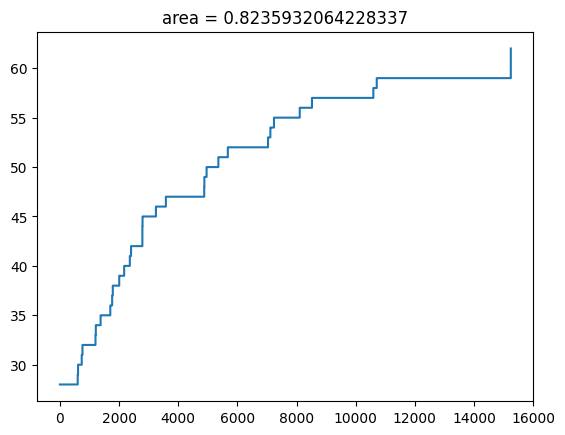

In [25]:
curr = time.time()
lr_area, lr_x, lr_y = LOOCV(positive.iloc[:,1:-1].values, negative.iloc[:,1:-1].values, 25, 
      model='LR', ks_test=True, features_left=250, graph=True, equation=True)
lr_time = time.time()-curr

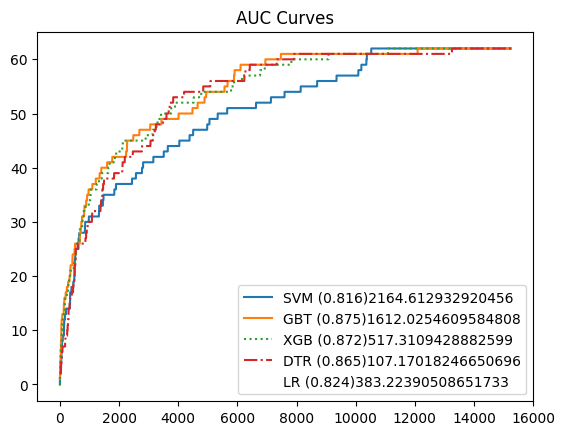

In [26]:
plt.plot(svm_x, svm_y, label = "SVM ("+str(round(svm_area, 3))+")"+str(svm_time))
plt.plot(gbr_x, gbr_y, label = "GBT ("+str(round(gbr_area, 3))+")"+str(gbr_time), linestyle="-")
plt.plot(xgb_x, xgb_y, label = "XGB ("+str(round(xgb_area, 3))+")"+str(xgb_time), linestyle=":")
plt.plot(dtr_x, dtr_y, label = "DTR ("+str(round(dtr_area, 3))+")"+str(dtr_time), linestyle="-.")
plt.plot(lr_x, lr_y, label = "LR ("+str(round(lr_area, 3))+")"+str(lr_time), linestyle=" ")
plt.title("AUC Curves")
plt.legend()
plt.show()

In [44]:
graphs = [method_area, method_x, method_y, pearson_area, pearson_x, pearson_y, spearman_area, spearman_x, spearman_y,]
pd.Series(graphs).to_csv(r"C:\Users\justi\Coding\Coding_Project\Han Xu\Trimmed data\graphs.csv", index = False)

In [8]:
def area_table(positive, negative, trials, model='SVR', feat_arr=[]):
    areas = []
    for i in feat_arr:
        print(i)
        areas.append(LOOCV(positive, negative, trials, model=model, ks_test=True, features_left=i))
    return areas

In [71]:
feature_arr = [10, 20, 50, 100, 124, 150, 200, 250, 300, 349]
areas = area_table(positive.iloc[:,1:-1].values, negative.iloc[:,1:-1].values, 20, 
                       model='GBR', feat_arr=feature_arr)

10
20
50
100
124
150
200
250
300
349


In [23]:
input_data = data.copy().sample(frac=1, random_state=1, ignore_index=True)
input_data['oncogene'] = np.isin(input_data.iloc[:,0], oncogenes)

# remove specific columns
drop_index = input_data.columns[['CRISPR' in i for i in input_data.columns]]
input_data.drop(drop_index, axis=1, inplace=True)
drop_index = input_data.columns[['copy_num' in i for i in input_data.columns]]
input_data.drop(drop_index, axis=1, inplace=True)
drop_index = input_data.columns[['gene_exp' in i for i in input_data.columns]]
input_data.drop(drop_index, axis=1, inplace=True)

# split into positive and negative
positive = input_data.iloc[list(compress(range(len(input_data)), input_data.iloc[:,-1]))].reset_index(drop=True)
negative = input_data.drop(list(compress(range(len(input_data)), input_data.iloc[:,-1]))).reset_index(drop=True)

feature_arr = [1, 2, 5, 7, 10, 13]
areas = area_table(positive.iloc[:,1:-1].values, negative.iloc[:,1:-1].values, 20, 
                       model='GBR', feat_arr=feature_arr)
print(areas)

1
2
5
7
10
13
[0.7502253662995911, 0.7553759914001067, 0.7271829847385751, 0.7402478817683954, 0.7467454143777351, 0.750943787508147]


In [72]:
feature_area = np.array([feature_arr, areas])

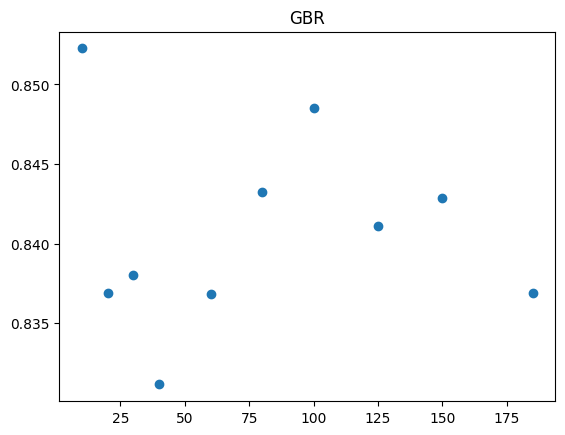

In [8]:
plt.scatter([10, 20, 30, 40, 60, 80, 100, 125, 150, 185], [0.8522559907229497, 0.8368654827705877, 0.8380526235599834, 0.8311466806612438, 0.836799883190425, 0.8432476870857704, 0.8485379758085677, 0.8410987718065701, 0.8428678443554736, 0.8368633666550985])
plt.title('GBR')
plt.show()

In [9]:
# Return a score for each negative value indicating its likeness to the positive values
def ks_pvalue(pos, neg):
    
    # Check feature length
    if len(pos[0]) != len(neg[0]):
        return "inconsistent feature lengths"

    p_val = np.zeros(len(pos[0]))

    # KS Test
    for j in range(0, len(pos[0])):
        _, p_value = stats.kstest(pos[:,j], neg[:,j])
        p_val[j] = p_value

    return p_val

In [9]:
p_val = ks_pvalue(positive.iloc[:,1:-1].values, negative.iloc[:,1:-1].values)

In [10]:
# Convert your data into multiple visual heatmaps
# data: an array of numbers
# dimensions: a multi-dimensional array with positive indicating the different dimensions
def heatmap(data, dimensions, cmap='hot', min=None, max=None, flip=False, axes=False, colorbar=False):
    index = 0
    for dim in dimensions:
        mat = np.reshape(data[index:index+dim[0]*dim[1]], (dim[0],dim[1]))
        if flip:
            mat = np.flip(mat, 0)
        if min != None and max != None:
            im = plt.imshow(mat, cmap=cmap, interpolation='nearest', vmin=min, vmax=max)
        else:
            im = plt.imshow(mat, cmap=cmap, interpolation='nearest')
        if colorbar:
            plt.colorbar(im)
        if not axes:
            plt.axis('off')
        plt.show()
        index += dim[0]*dim[1]

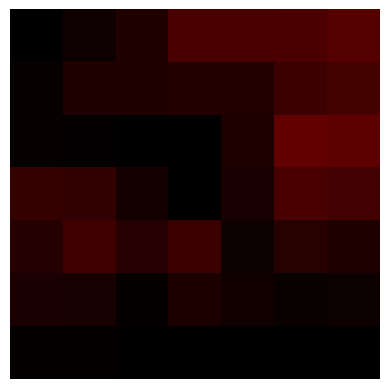

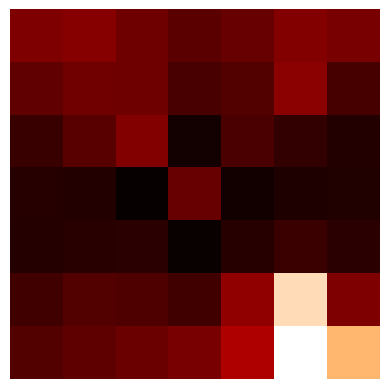

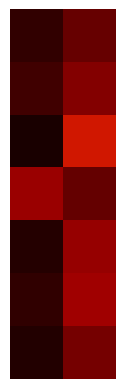

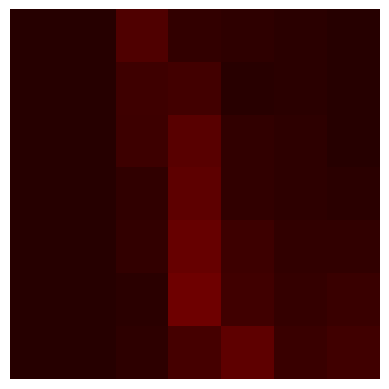

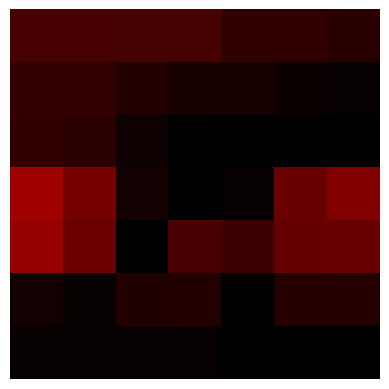

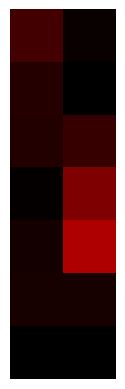

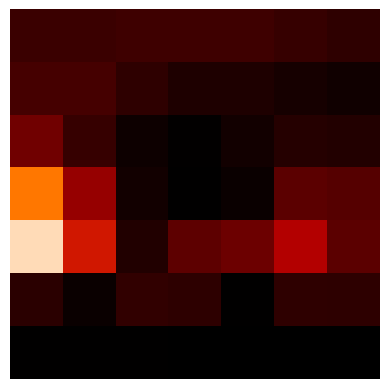

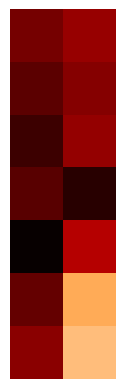

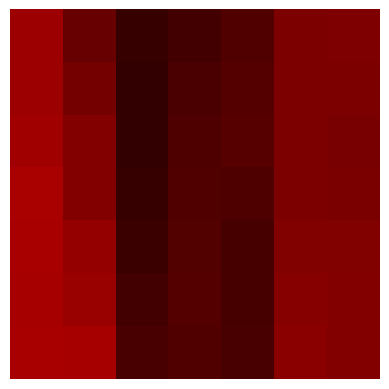

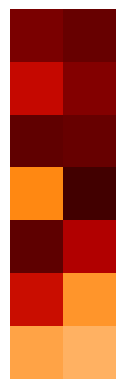

In [16]:
log_p_val = np.log10(p_val)
heatmap(log_p_val, [[7,7],[7,7],[7,2],[7,7],[7,7],[7,2],[7,7],[7,2],[7,7],[7,2]], 
        cmap='gist_heat_r', min=np.min(log_p_val), max=np.max(log_p_val), flip=True, axes=False, colorbar=False)